## This structure is for BERT training

In [1]:
from transformers import AutoModel, AutoTokenizer, BertModel, PreTrainedTokenizer, get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset 
from torch.nn.utils.rnn import pad_sequence # for dynamic padding
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# set seeds
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(114514)

In [3]:
# import pretrained model
model : BertModel = AutoModel.from_pretrained("microsoft/deberta-v3-base")
tokenizer : PreTrainedTokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

model

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): StableDropout()
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): StableDropout()
            (dropout): StableDropout()
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): StableDropout()
          )
        )
        (intermedia

In [4]:
# import datasets

train_df = pd.read_csv("../preprocessed_dataset/train.csv").iloc[:,1:]
validation_df = pd.read_csv("../preprocessed_dataset/validation.csv").iloc[:,1:]
test_df = pd.read_csv("../preprocessed_dataset/test.csv").iloc[:,1:]
train_df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [5]:
# try to use tokenizer api
tokenizer("hello world")

{'input_ids': [1, 12018, 447, 2], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [6]:
## Define model
class SentimentClassifier(nn.Module):
    def __init__(
            self, 
            bert : BertModel
        ) -> None:
        super().__init__()
        self.bert = bert
        self.fc = nn.Linear(768, 1) # total 768 dim output
        
    def forward(
            self,
            input_ids : torch.Tensor,
            attention_mask : torch.Tensor
        ) -> torch.Tensor:
        outputs = self.bert.forward(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        # get the output of [CLS] position (first position) for training 
        cls_output = outputs.last_hidden_state[:,0,:] # [B, seqlen, embed]
        return self.fc.forward(cls_output)

In [7]:
# define dataset and data loader
from typing import Any


class CustomizeDataset(Dataset):
    def __init__(
            self,
            tokenizer : PreTrainedTokenizer,
            df : pd.DataFrame
        ) -> None:
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(
            self, 
            index : int
        ) -> dict:
        
        inputs = self.df.iloc[index,0] # 0 is text
        label = self.df.iloc[index, 1] # 1 is label
        
        tok = self.tokenizer(inputs)
        
        return {
            "input_ids" : tok["input_ids"],
            "label" : label
        }
        
# collater function (used for dynamic padding to save memory)
class Collater:
    def __init__(
            self,
            tokenizer : PreTrainedTokenizer
        ) -> None:
        self.tokenizer = tokenizer 
    
    def __call__(
            self,
            instances : list
        ) -> Any:
        # __call__ is for function-like object
        input_ids = [torch.tensor(instance["input_ids"], dtype = torch.int64) for instance in instances]
        label = [torch.tensor(instance["label"], dtype = torch.int64) for instance in instances]
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id) # only pad for each epoch
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id).type(torch.int64)
        
        return {
            "input_ids": input_ids,
            "label": torch.tensor(label),
            "attention_mask": attention_mask # mask the pad position
        }

In [8]:
# Hyper paramaters

val_steps = 100 # compute validation error every n step

num_train_epochs = 2

batch_size = 16
lr = 5e-6
weight_decay = 1e-7

warmup_ratio=0.05

In [9]:
# create dataset and data loader

collate_fn = Collater(tokenizer)

train_ds = CustomizeDataset(
    tokenizer = tokenizer,
    df = train_df
)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    collate_fn = collate_fn,
    shuffle = True
)

val_ds = CustomizeDataset(
    tokenizer = tokenizer,
    df = validation_df
)

val_loader = DataLoader(
    dataset = val_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

test_ds = CustomizeDataset(
    tokenizer = tokenizer,
    df = test_df
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

In [10]:
# compute warmup status
num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:1068, warm up: 53


In [11]:
# Set optimizer, loss_fn and so on

cls_model = SentimentClassifier(model)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(
    params = cls_model.parameters(),
    lr = lr,
    weight_decay = weight_decay
)

scheduler  = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_training_steps
)

In [12]:
# compute accuracy for wach data loader

def compute_accuracy(data_loader: DataLoader) -> float:
    
    cls_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

def compute_loss(data_loader: DataLoader) -> float:
    total_loss = 0
    cls_model.eval()
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model.forward(input_ids, attention_mask)
            loss = loss_fn.forward(
                input = logits,
                target = labels
            )
            
            total_loss += loss.detach().cpu()
            
        total_loss /= len(val_loader)
        
        return total_loss
    

In [13]:
# Training loop

cls_model.to(device)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        
        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
        
        step += 1
    
    

[1/1068] train loss: [0.7727] (epoch [1/2])
[1/1068] validation loss: [0.7128] validation accuracy: [0.5000]
[2/1068] train loss: [0.7663] (epoch [1/2])
[3/1068] train loss: [0.6237] (epoch [1/2])
[4/1068] train loss: [0.7126] (epoch [1/2])
[5/1068] train loss: [0.6752] (epoch [1/2])
[6/1068] train loss: [0.6224] (epoch [1/2])
[7/1068] train loss: [0.7043] (epoch [1/2])
[8/1068] train loss: [0.7354] (epoch [1/2])
[9/1068] train loss: [0.6557] (epoch [1/2])
[10/1068] train loss: [0.5663] (epoch [1/2])
[11/1068] train loss: [0.7534] (epoch [1/2])
[12/1068] train loss: [0.7488] (epoch [1/2])
[13/1068] train loss: [0.6789] (epoch [1/2])
[14/1068] train loss: [0.7091] (epoch [1/2])
[15/1068] train loss: [0.6261] (epoch [1/2])
[16/1068] train loss: [0.6283] (epoch [1/2])
[17/1068] train loss: [0.6461] (epoch [1/2])
[18/1068] train loss: [0.7416] (epoch [1/2])
[19/1068] train loss: [0.7277] (epoch [1/2])
[20/1068] train loss: [0.7264] (epoch [1/2])
[21/1068] train loss: [0.6542] (epoch [1/2])

In [14]:
# test loss
cls_model.eval()

test_loss = compute_loss(test_loader)
    
test_acc = compute_accuracy(test_loader)

print(f"Test Loss: [{test_loss:.4f}]\nTest accuracy: [{test_acc:.4f}]")

Test Loss: [0.2462]
Test accuracy: [0.9024]


In [15]:
test_word = "It is the law of Inverse Relevance: the less you intend to do about something, the more you have to keep talking about it."

toks = tokenizer(test_word, return_tensors="pt")
F.sigmoid(cls_model.forward(toks["input_ids"].to(device), toks["attention_mask"].to(device))).detach().cpu().item()

0.10186424106359482

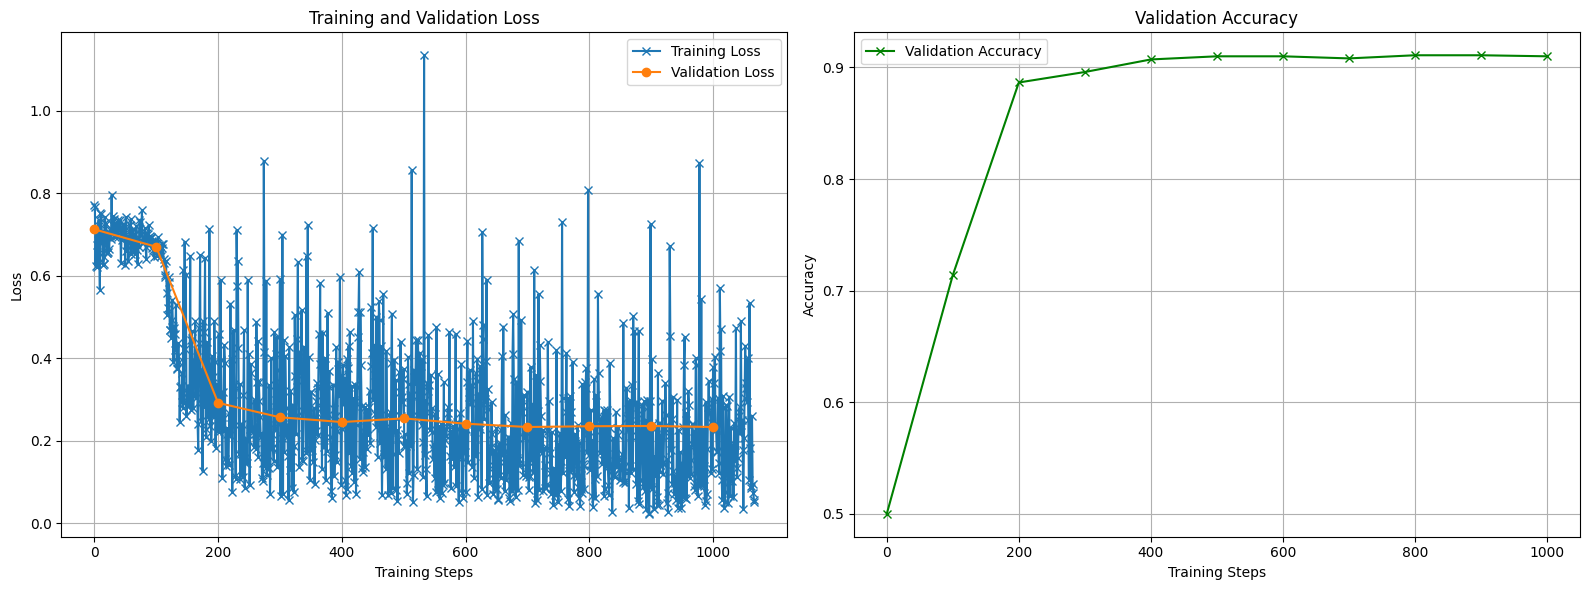

In [16]:
# visualization 1: train / val curve

val_steps = [i * val_steps for i in range(len(val_losses))]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# loss
ax1.plot(train_losses, label='Training Loss', marker='x')
ax1.plot(val_steps, val_losses, label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# acc
ax2.plot(val_steps, val_accs, label='Validation Accuracy', color='green', marker='x')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()


plt.tight_layout()
plt.show()

In [17]:
# compute predictions and labels for confusion matrix computing
def compute_pedictions_and_labels(
        model : nn.Module, 
        test_loader : DataLoader, 
        device : torch.device
    ) -> tuple:
    
    model.to(device)
    
    model.eval()
    
    # Lists to store all predictions and actual labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    return all_predictions, all_labels

all_predictions, all_labels = compute_pedictions_and_labels(cls_model, test_loader, device)

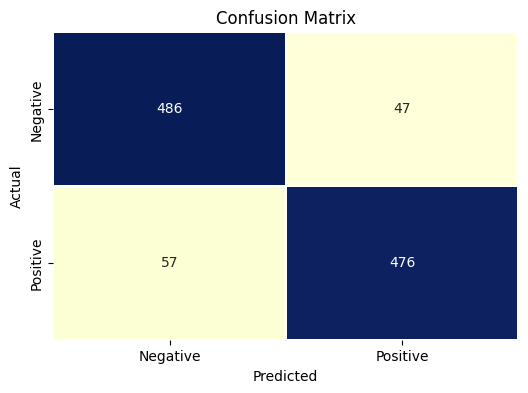

In [18]:
# visualization 2: confusion matrix

def plot_confusion(
        all_predictions : list, 
        all_labels : list
    ) -> None:      
            
    cm = confusion_matrix(all_labels, all_predictions) # from sklearn
            
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.2, cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
    plt.show()
    
plot_confusion(all_predictions, all_labels)

In [19]:
def plot_f1_score(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    f1 = f1_score(all_labels, all_predictions)
    print("F1 Score: ", f1)
    
plot_f1_score(all_predictions, all_labels)

F1 Score:  0.9015151515151515


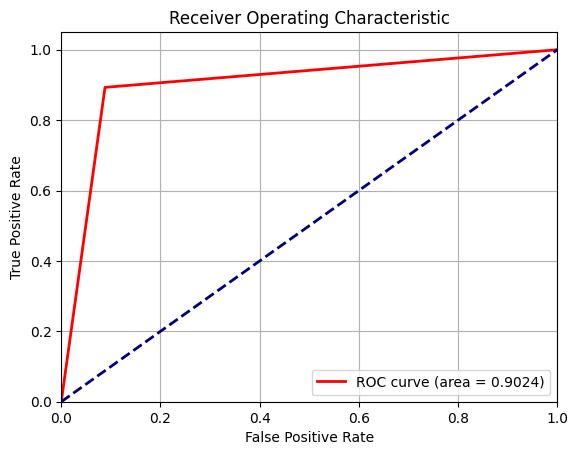

In [20]:
def plot_roc_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label=f"ROC curve (area = {roc_auc:0.4f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
plot_roc_curve(all_predictions, all_labels)

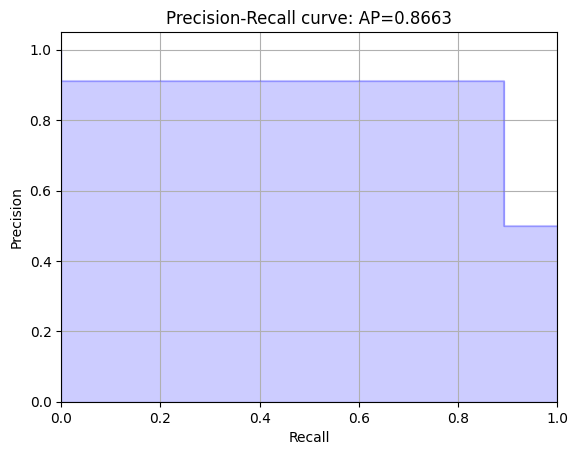

In [21]:
def plot_precision_recall_curve(
        all_predictions : list, 
        all_labels : list
    ) -> None:
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
    average_precision = average_precision_score(all_labels, all_predictions)

    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Precision-Recall curve: AP={average_precision:.4f}")
    plt.grid(True)
    plt.show()
    
plot_precision_recall_curve(all_predictions, all_labels)